# P5 - Convolutioneel neuraal netwerk

Voor deze opdracht moeten we de dataset _"cifar-10"_ proberen classificeren met behulp van een  Convolutioneel neuraal netwerk oftewel een CNN. In deze notebook ga ik per stap laten zien hoe ik tot mijn eind score ben gekomen en hoe ik mijn netwerk heb opgebouwd.

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, schedules
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

## Data exploration

We beginnen eerst met een de inladen van de data en de shape van de data uitprinten. Op deze manier kunnen we zien of we de shape van de data moeten aanpassen in de volgende stap. 

In [2]:
(trainX, trainy), (testX, testy) = cifar10.load_data()

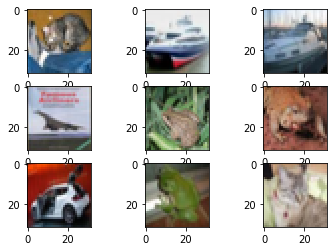

In [3]:
# Plot 9 fotos van de data om zien wat de dataset precies inhoudt
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(testX[i])
plt.show()

In [4]:
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


## Data preparation

Zoals we zien is de shape van de data is niet helemaal zoals we willen. Daarom gaan we eerst de de type aapassen naar floats en zorgen data de images genormaliseerd zijn. Vervolgens willen we de target vullen voor de inputs/ alle mogelijke classes.  

In [5]:
trainX = trainX.astype('float32')         
testX = testX.astype('float32')

trainX /= 255                              
testX /= 255

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [6]:
trainy = tf.keras.utils.to_categorical(trainy)
testy = tf.keras.utils.to_categorical(testy)

print(f"Y_train: {trainy.shape}, Y_test: {testy.shape}")

Y_train: (50000, 10), Y_test: (10000, 10)


Nu we de data hebben georganiseerd, kunnen we aan de slag gaan met een simpele model bouwen! 

##  Modelling

Om te beginnen maken we een model die een acceptable score zou halen en vervolgens gaan we proberen om het score verbteren. Hieronder leg ik de instelling van de baseline model uit:

We beginnen met een simpele netwerk die uit 2 convolution layer en 1 fully connected layer. 

__1. Conv Layer__

De eerste laag bestaat uit 32 3x3 filter met ReLU. We zetten we de input van deze laag gelijk aan de shape van de train data en dat is 32x32x3. 

We laten de stride en de padding op de default value zitten. In de volgende model gaan we hier mee spelen maar voor nu houden we het op 1 en "vaild".

Wel voegen we een Batch normalization toe. De output van deze laag (de activatie map) komt op 30x30x32. 


__2. Conv Layer__ 

De tweede laag bestaat uit 128 filters van 3x3 en hier passen we een max pooling op dat de size naar 14x14x 128 wordt verkleint. 

Deze laag bevat ook flatten, dat doen we im de fully connected layer een input te geven van een vactor van 25088 te geven. 

__3. Fully connected layer__

Het neurale netwerk krijgt nu 25088 als input van laag 2. Deze laag is meteen de output laag en bestaat uit 10 nodes. Dat zijn de aantaal mogelijke klassen in deze dataset. 

    

In [7]:
model = Sequential([keras.Input(shape=(32, 32, 3)),
                    layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu"),
                    layers.BatchNormalization(axis= -1),
                    
                    layers.Conv2D(filters = 128, kernel_size=(3, 3), activation="relu"),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    
                    layers.Flatten(),
                    layers.Dropout(0.2),
                    layers.Dense(10, activation="softmax")])

Laat ons nu het model settings bekijken

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                2

Ziet er voor nu goed uit. Dus tijd om te compilen. 

### Compilen

Voor het compilen van het model maken we gebruik van de optimizer Adam en de los functie. 

In [9]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Nu is het eindelijk tijd om het model te laten fitten!

### Fitten

Voor het fitten maken we gebruik van batch size van 128 en 5 epoches 

In [10]:
history = model.fit(trainX, trainy, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 387s 615ms/step - loss: 1.6345 - accuracy: 0.4487 - val_loss: 1.2085 - val_accuracy: 0.6178
Epoch 2/5
625/625 [==============================] - 466s 746ms/step - loss: 0.9153 - accuracy: 0.6864 - val_loss: 1.3732 - val_accuracy: 0.5585
Epoch 3/5
625/625 [==============================] - 352s 563ms/step - loss: 0.7042 - accuracy: 0.7587 - val_loss: 0.9654 - val_accuracy: 0.6800
Epoch 4/5
625/625 [==============================] - 278s 445ms/step - loss: 0.5546 - accuracy: 0.8101 - val_loss: 1.0290 - val_accuracy: 0.6771
Epoch 5/5
625/625 [==============================] - 257s 412ms/step - loss: 0.4514 - accuracy: 0.8455 - val_loss: 1.1376 - val_accuracy: 0.6586


### Evalueren

Laat we nu kijken hoe goed de resultaten zijn van het model op de test set. 

In [11]:
loss, accuracy = model.evaluate(testX, testy)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}") 

313/313 [==============================] - 15s 49ms/step - loss: 1.1345 - accuracy: 0.6566
Test loss: 1.1345
Test accuracy: 0.6566


### Plot the results

In [25]:
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

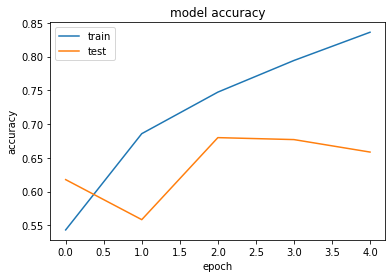

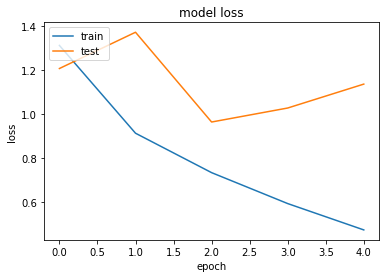

In [26]:
plot(history)

### Conclusie resultaten

We zien data de score van dit model rond de 66% ligt. De loss en de accrucy van de test en de train model ligt ver van elkaar af. Dit hebben we kunnen halen met 2 conv lagen. Dit kunnen we zeker nog vebeteren! 

## Verbterende model 

Bij deze model gaan we een extra laag toevoegen. ook voegen we meer Dropout en pooling aan deze model.

__1. Conv layer__ 

De eerste laag bestaat weer uit 32 3x3 filter met ReLU. We zetten we de input van deze laag gelijk aan de shape van de train data en dat is 32x32x3. Ook zetten we de padding aangezien dat handig kan zijn voor de filter. Door de pooling ook aan te zetten verlagen we het aantaal inputs naar 16x16x3. 


__2. Conv layer__ 

De tweede layer bestaat uit 64 3x3 filter. Dat heb ik gekozen op basis van 32(vorige layer)* 2 te doen. De activatie functie blijft ReLU en we zetten de padding weer aan. 
We maken ook gebruik van een batch normalizer en een dropout. 


__3. Conv layer__

De tweede layer bestaat uit 128 3x3 filter. Dat heb ik gekozen op basis van 64(vorige layer)* 2 te doen. De activatie functie blijft ReLU en we zetten de padding weer aan. 
We maken ook gebruik van een batch normalizer en een dropout. 

Na deze layer gaan we Flatten. De input voor de full connected layer wordt 8x8x128 oftewel 8192 nodes.

__4. fully connected layer__ 

We zijn eindelijk bij de laatste twee layers aangekomen. De eerste layer krijgt input van 450 hier wordt nog steeds gebruik van de ReLU activatie functie gedaan. We maken ook gebruik van een batch normalizer en een dropout. 

De laatste layer oftewel de output layer bestaat uit 10 nodes. Met de kernel_regularizer zorgen we ervoor dat er minder overfitting van het model bij de traninen kan kommen. 

In [14]:
model_2 = Sequential([keras.Input(shape=(32, 32, 3)),
                    layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu", padding = "same"),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    layers.BatchNormalization(axis= -1),
                    layers.Dropout(0.2),

                    layers.Conv2D(filters = 64, kernel_size=(3, 3), activation="relu", padding = "same"),
                    layers.BatchNormalization(axis= -1),
                    layers.Dropout(0.3),
                    
                    layers.Conv2D(filters = 128, kernel_size=(3, 3), activation="relu", padding = "same"),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    layers.BatchNormalization(axis= -1),
                    layers.Dropout(0.4),
                      
                    layers.Flatten(),
                    layers.Dense(450, activation = "relu"),
                    layers.BatchNormalization(axis= -1),
                    layers.Dropout(0.5),
                      
                    layers.Dense(10,kernel_regularizer=tf.keras.regularizers.l2(0.2), activation="softmax")])

In [15]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)       

Ziet er goed uit, laten we compilen! 

In [16]:
model_2.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

Tijd om te fitten:

In [17]:
history_2 = model_2.fit(trainX, trainy, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30
313/313 [==============================] - 253s 801ms/step - loss: 3.5374 - accuracy: 0.4006 - val_loss: 3.9535 - val_accuracy: 0.1042
Epoch 2/30
313/313 [==============================] - 250s 799ms/step - loss: 1.2947 - accuracy: 0.5878 - val_loss: 1.4273 - val_accuracy: 0.5573
Epoch 3/30
313/313 [==============================] - 247s 788ms/step - loss: 1.1401 - accuracy: 0.6476 - val_loss: 1.1024 - val_accuracy: 0.6575
Epoch 4/30
313/313 [==============================] - 244s 780ms/step - loss: 1.0521 - accuracy: 0.6819 - val_loss: 1.2878 - val_accuracy: 0.5953
Epoch 5/30
313/313 [==============================] - 1051s 3s/step - loss: 0.9748 - accuracy: 0.7058 - val_loss: 1.1511 - val_accuracy: 0.6401
Epoch 6/30
313/313 [==============================] - 248s 792ms/step - loss: 0.9222 - accuracy: 0.7235 - val_loss: 1.4218 - val_accuracy: 0.5561
Epoch 7/30
313/313 [==============================] - 7510s 24s/step - loss: 0.8724 - accuracy: 0.7478 - val_loss: 0.9779 - va

En nu eindelijk tijd om de score te checken! 

In [18]:
loss, accuracy = model_2.evaluate(testX, testy)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}") 

313/313 [==============================] - 12s 37ms/step - loss: 0.7514 - accuracy: 0.7877
Test loss: 0.7514
Test accuracy: 0.7877


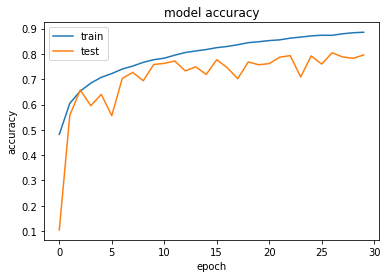

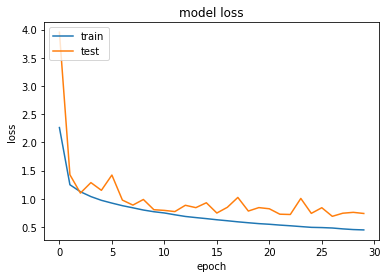

In [27]:
plot(history_2)

### Conclusie 

De score is zeker omhoog gegaan! We gaan nu richting de 80%! Het runnen van de fit van een model duurt heel lang bij mij. Ik zou het graag willen testen maar dat gaat niet met een Aldi laptop helaas :( 
De loss en de accrucy van de train en de test data komen ongeveer overeen en dat is een goed teken.

## Data augmentation

Laten we nu een laatste ding proberen, namelijk hoe zou het model preseteren bij een augmentated data?


In [28]:
rotation_range_val = 15
width_shift_val = 0.15
height_shift_val = 0.15
shear_range_val = 25
zoom_range_val = [0.9,1.1]

In [29]:
datagen = ImageDataGenerator(rotation_range = rotation_range_val,
                             width_shift_range = width_shift_val,
                             height_shift_range = height_shift_val,
                             zoom_range=zoom_range_val)

In [30]:
datagen.fit(testX)

In [31]:
X_test_augmented, Y_test_augmented = next(datagen.flow(testX, testy, batch_size=testX.shape[0], shuffle=False))

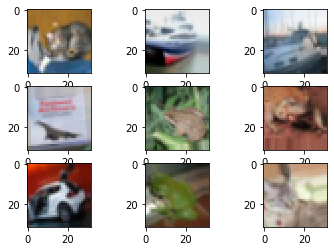

In [32]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow((X_test_augmented[i] * 255).astype(np.uint8))
plt.show()

In [33]:
loss, accuracy = model_2.evaluate(X_test_augmented, Y_test_augmented)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 12s 37ms/step - loss: 1.1486 - accuracy: 0.6652
Test loss: 1.1486
Test accuracy: 0.6652


De score is hier ook niet te slecht! Het model doet het wat mij betreft goed!